# Rollinger bands and RSI strategy
## Simplest, yet quite effective...
- Buy when it is at a discounted px (<= 2 sd) and oversold
- Sell when it is at a premium px (>= 2 sd) and overbought

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import talib

In [2]:
goog = yf.Ticker('TSM')

#get historical price (5 years)
df = goog.history(period="5y")
df = df.reset_index()

# Make date to pure date
df['Date'] = pd.to_datetime(df['Date']).dt.date
print(df)

            Date       Open        High        Low       Close    Volume   
0     2018-05-25  33.631135   33.966589  33.484914   33.803162   5403000  \
1     2018-05-29  33.106458   33.166667  32.710795   32.822613   7198200   
2     2018-05-30  32.943030   33.029045  32.745200   32.977436   8413400   
3     2018-05-31  32.968839   33.424707  32.934433   33.287086   8129400   
4     2018-06-01  33.536517   33.717144  33.373090   33.717144   5970000   
...          ...        ...         ...        ...         ...       ...   
1254  2023-05-19  92.129997   92.790001  91.559998   92.580002   9292700   
1255  2023-05-22  92.070000   92.440002  91.199997   91.720001   9259800   
1256  2023-05-23  91.000000   91.339996  90.330002   90.440002   7656700   
1257  2023-05-24  89.279999   90.150002  89.180000   90.129997   9237700   
1258  2023-05-25  97.059998  101.250000  96.980003  101.139999  27520951   

      Dividends  Stock Splits  
0           0.0           0.0  
1           0.0        

In [3]:
print(df['Close'].rolling(30).mean())

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
1254    86.088667
1255    86.178667
1256    86.218667
1257    86.327334
1258    86.797000
Name: Close, Length: 1259, dtype: float64


In [4]:
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['Bollinger High'], df['Mean'], df['Bollinger Low'] = talib.BBANDS(df['Close'], timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
print(df)

            Date       Open        High        Low       Close    Volume   
0     2018-05-25  33.631135   33.966589  33.484914   33.803162   5403000  \
1     2018-05-29  33.106458   33.166667  32.710795   32.822613   7198200   
2     2018-05-30  32.943030   33.029045  32.745200   32.977436   8413400   
3     2018-05-31  32.968839   33.424707  32.934433   33.287086   8129400   
4     2018-06-01  33.536517   33.717144  33.373090   33.717144   5970000   
...          ...        ...         ...        ...         ...       ...   
1254  2023-05-19  92.129997   92.790001  91.559998   92.580002   9292700   
1255  2023-05-22  92.070000   92.440002  91.199997   91.720001   9259800   
1256  2023-05-23  91.000000   91.339996  90.330002   90.440002   7656700   
1257  2023-05-24  89.279999   90.150002  89.180000   90.129997   9237700   
1258  2023-05-25  97.059998  101.250000  96.980003  101.139999  27520951   

      Dividends  Stock Splits        RSI  Bollinger High       Mean   
0           0.0 

In [5]:
def strategy(data):
    pos = 0
    buy_price = []
    sell_price = []
    for i in range(len(data)):
        if data['Close'][i] < data['Bollinger Low'][i] and data['RSI'][i] < 30 and pos == 0:
                buy_price.append(data['Close'][i])
                sell_price.append(np.nan)
                pos = 1
        elif data['Close'][i] > data['Bollinger High'][i] and data['RSI'][i] > 70 and pos == 1:
            sell_price.append(data['Close'][i])
            buy_price.append(np.nan)
            pos = 0
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
    return (buy_price, sell_price)
buy_price, sell_price = strategy(df)
df['Buy'] = buy_price
df['Sell'] = sell_price
print(df)

            Date       Open        High        Low       Close    Volume   
0     2018-05-25  33.631135   33.966589  33.484914   33.803162   5403000  \
1     2018-05-29  33.106458   33.166667  32.710795   32.822613   7198200   
2     2018-05-30  32.943030   33.029045  32.745200   32.977436   8413400   
3     2018-05-31  32.968839   33.424707  32.934433   33.287086   8129400   
4     2018-06-01  33.536517   33.717144  33.373090   33.717144   5970000   
...          ...        ...         ...        ...         ...       ...   
1254  2023-05-19  92.129997   92.790001  91.559998   92.580002   9292700   
1255  2023-05-22  92.070000   92.440002  91.199997   91.720001   9259800   
1256  2023-05-23  91.000000   91.339996  90.330002   90.440002   7656700   
1257  2023-05-24  89.279999   90.150002  89.180000   90.129997   9237700   
1258  2023-05-25  97.059998  101.250000  96.980003  101.139999  27520951   

      Dividends  Stock Splits        RSI  Bollinger High       Mean   
0           0.0 

PnL results

In [6]:
#PnL results
buy_signals = df['Buy'].dropna().reset_index(drop=True)
sell_signals = df['Sell'].dropna().reset_index(drop=True)
pnl = sell_signals - buy_signals
accruacy = pnl[pnl>0].sum()/abs(pnl).sum()
print('Accruacy (pro-rata): ', accruacy)
print('Total PnL: ', pnl.sum())
print('PnL record in pair:\n', pnl)

Accruacy (pro-rata):  0.577830323310768
Total PnL:  6.303749084472656
PnL record in pair:
 0     1.506790
1     5.880135
2    16.013321
3   -17.096497
dtype: float64


In [7]:
buy_days = df['Date'][df['Buy'].notna()].reset_index(drop=True)
sell_days = df['Date'][df['Sell'].notna()].reset_index(drop=True)
print('Buy days:\n', buy_days)
print('Sell days:\n', sell_days)
trade_duration = sell_days - buy_days
# transfrom trade_duration to numbers
trade_duration = trade_duration.apply(lambda x: x.days)
print('Trade duration: ', trade_duration)
print('Average trade duration: ', trade_duration.mean())

Buy days:
 0    2018-10-10
1    2019-05-20
2    2021-08-20
3    2022-03-07
Name: Date, dtype: object
Sell days:
 0    2019-03-21
1    2019-07-19
2    2021-09-07
3    2022-11-15
Name: Date, dtype: object
Trade duration:  0    162
1     60
2     18
3    253
Name: Date, dtype: int64
Average trade duration:  123.25


Plotted strategy

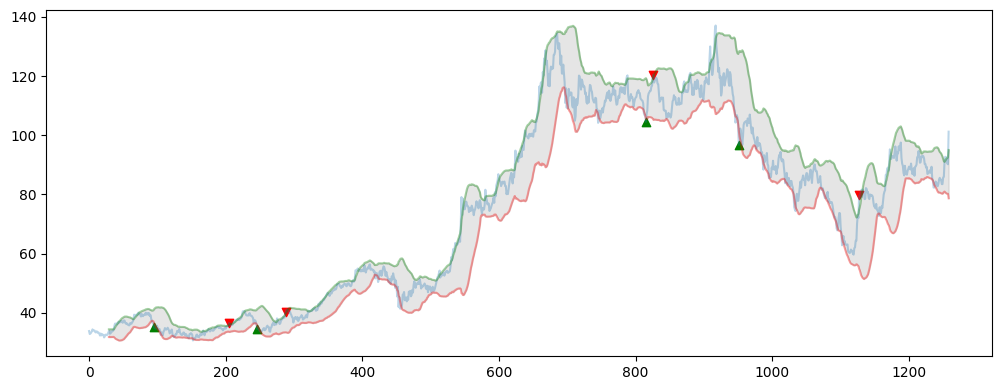

<Figure size 1220x450 with 0 Axes>

<Figure size 1220x450 with 0 Axes>

In [8]:
# Scale the plot size larger to be easier to see, now too packed
plt.figure(figsize=(12.2, 4.5))

plt.plot(df['Close'], label='Close', alpha = 0.3)
plt.plot(df['Bollinger High'], label='Bollinger High', color='green', alpha=0.35)
plt.plot(df['Bollinger Low'], label='Bollinger Low', color='red', alpha=0.35)
plt.fill_between(df.index, df['Bollinger High'], df['Bollinger Low'], color='grey', alpha=0.2)
plt.scatter(df.index, df['Buy'], label='Buy', marker='^', color='green')
plt.scatter(df.index, df['Sell'], label='Sell', marker='v', color='red')
plt.show()

# Scale the plot size larger to be easier to see, now too packed
plt.figure(figsize=(12.2, 4.5))